In [1]:
# Essentials
import gc
import numpy as np
import pandas as pd
import datetime
import random
import warnings
import string
from skopt.space import Real, Categorical, Integer
warnings.filterwarnings("ignore")
import functools
import dask
import os
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Tools and metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.preprocessing import PowerTransformer
from skopt import BayesSearchCV

#bbq packages
import helper as hp
import stats
import product_info as pi

In [2]:
# Purge 交叉验证函数
# TODO: make GitHub GIST
# TODO: add as dataset
# TODO: add logging with verbose

import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [3]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
    
# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

# 1 数据处理

## 1.1读取数据

In [4]:
data = pd.read_csv("ag2012.csv",index_col='Unnamed: 0')

数据有74684行，125列

In [5]:
data.shape

(74684, 124)

In [7]:
data.tail()

,Unnamed: 0.1,Unnamed: 0.1.1,Time,OpenPrice,HighPrice,LowPrice,ClosePrice,VWAP,TWAP,ModePrice,...,ExtraTA_CDLSPINNINGTOP,ExtraTA_CDLSTALLEDPATTERN,ExtraTA_CDLSTICKSANDWICH,ExtraTA_CDLTAKURI,ExtraTA_CDLTASUKIGAP,ExtraTA_CDLTHRUSTING,ExtraTA_CDLTRISTAR,ExtraTA_CDLUNIQUE3RIVER,ExtraTA_CDLUPSIDEGAP2CROWS,ExtraTA_CDLXSIDEGAP3METHODS
74679,74679,549,2.020112e+13,4897.5,4897.5,4894.5,4894.5,4895.448017,4895.350000,4895,...,0,0,0,0,0,0,0,0,0,0
74680,74680,550,2.020112e+13,4894.5,4895.5,4892.5,4892.5,4894.184641,4894.116667,4894,...,0,0,0,0,0,0,0,0,0,0
74681,74681,551,2.020112e+13,4893.5,4897.5,4892.5,4897.5,4895.466537,4895.566667,4897,...,0,0,0,0,0,0,0,0,0,0
74682,74682,552,2.020112e+13,4897.5,4899.5,4897.5,4899.5,4898.937931,4899.016667,4899,...,0,0,0,0,0,0,0,0,0,0
74683,74683,553,2.020112e+13,4899.5,4900.5,4898.5,4898.5,4899.523593,4899.333333,4899,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data.head()

,Unnamed: 0.1,Unnamed: 0.1.1,Time,OpenPrice,HighPrice,LowPrice,ClosePrice,VWAP,TWAP,ModePrice,...,ExtraTA_CDLSPINNINGTOP,ExtraTA_CDLSTALLEDPATTERN,ExtraTA_CDLSTICKSANDWICH,ExtraTA_CDLTAKURI,ExtraTA_CDLTASUKIGAP,ExtraTA_CDLTHRUSTING,ExtraTA_CDLTRISTAR,ExtraTA_CDLUNIQUE3RIVER,ExtraTA_CDLUPSIDEGAP2CROWS,ExtraTA_CDLXSIDEGAP3METHODS
0,0,0,2.020051e+13,3697.0,3699.5,3694.5,3696.5,3696.831122,3697.183333,3696,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2.020051e+13,3696.5,3696.5,3693.5,3695.5,3695.113238,3695.300000,3695,...,0,0,0,0,0,0,0,0,0,0
2,2,2,2.020051e+13,3696.0,3696.0,3688.5,3693.0,3692.898551,3693.233333,3694,...,0,0,0,0,0,0,0,0,0,0
3,3,3,2.020051e+13,3692.0,3692.5,3686.5,3687.5,3689.487021,3689.850000,3690,...,0,0,0,0,0,0,0,0,0,0
4,4,4,2.020051e+13,3687.5,3688.5,3680.5,3681.5,3683.159609,3683.833333,3682,...,0,0,0,0,0,0,0,0,0,0


# 2 探索性数据分析

## 2.1查看特征

In [9]:
data.iloc[100:105,0:10]

,Unnamed: 0.1,Unnamed: 0.1.1,Time,OpenPrice,HighPrice,LowPrice,ClosePrice,VWAP,TWAP,ModePrice
100,100,100,2.020051e+13,3684.0,3684.5,3681.5,3683.5,3682.601322,3682.750000,3682
101,101,101,2.020051e+13,3683.5,3683.5,3681.5,3682.5,3682.031250,3681.783333,3681
102,102,102,2.020051e+13,3682.5,3684.5,3681.5,3684.5,3683.052326,3682.866667,3683
103,103,103,2.020051e+13,3684.5,3685.5,3683.5,3685.5,3684.475610,3684.266667,3684
104,104,104,2.020051e+13,3685.5,3686.5,3684.5,3685.5,3685.437086,3685.566667,3685


In [10]:
data.iloc[100:105,10:20]

,MedianPrice,Volume,Turnover,OI,HighIndex,LowIndex,CorrPV,CorrPOI,CorrAutoRtn,RtnMean
100,3682.5,454.0,25078515.0,26.0,0.033333,0.366667,-0.166690,-0.185766,-0.279089,-2.290377e-06
101,3681.5,448.0,24743250.0,72.0,0.000000,0.150000,0.154775,0.269349,-0.147489,-4.594495e-06
102,3683.5,172.0,9502275.0,18.0,0.833333,0.100000,-0.027370,-0.034722,-0.013989,9.205868e-06
103,3684.5,82.0,4531905.0,5.0,0.950000,0.233333,0.081434,-0.038951,-0.004953,4.601684e-06
104,3685.5,151.0,8347515.0,25.0,0.783333,0.050000,0.217610,0.352170,-0.000001,2.183659e-09


In [11]:
data.iloc[100:105,20:30]

,RtnStd,RtnSkew,RtnKurt,NetBuyVolume,SpreadRatio,ImbL1Mean,ImbL1Std,ImbL1Skew,CorrImbL1Mid,ImbL1Last
100,0.000142,-0.317735,0.903829,0,0.000303,0.302821,0.463141,-1.061269,-0.506280,0.630769
101,0.000122,0.206256,1.644951,0,0.000285,0.108925,0.591307,-0.176556,-0.594085,-0.682927
102,0.000079,1.575414,4.668289,0,0.000303,-0.215189,0.507661,0.043417,-0.819236,0.463918
103,0.000066,0.972629,11.896529,0,0.000290,-0.073479,0.495547,0.612179,-0.334739,-0.441176
104,0.000066,0.881528,12.050487,0,0.000280,-0.267480,0.435589,0.167636,-0.650201,0.135135


In [12]:
data.iloc[100:105,30:40]

,TD,ExtraTA_ADX,ExtraTA_ADXR,ExtraTA_APO,ExtraTA_AROON_DOWN,ExtraTA_AROON_UP,ExtraTA_AROONOSC,ExtraTA_BOP,ExtraTA_CCI,ExtraTA_CMO
100,20200507,26.362721,25.129539,-0.608974,100.000000,57.142857,-42.857143,-0.166667,-269.693252,-31.021515
101,20200507,28.217769,25.700602,-0.801282,100.000000,50.000000,-50.000000,-0.500000,-196.680973,-34.643998
102,20200507,29.249423,25.885430,-1.028846,100.000000,42.857143,-57.142857,0.666667,-121.293673,-20.961807
103,20200507,29.555191,26.445094,-1.256410,92.857143,35.714286,-57.142857,0.500000,-69.529386,-14.686491
104,20200507,29.224097,26.338259,-1.439103,85.714286,28.571429,-57.142857,0.000000,-45.151893,-14.686491


In [13]:
data.iloc[100:105,40:50]

,ExtraTA_DX,ExtraTA_MACD,ExtraTA_MACD_SIGNAL,ExtraTA_MACD_HIST,ExtraTA_MINUS_DI,ExtraTA_MINUS_DM,ExtraTA_MOM,ExtraTA_PLUS_DI,ExtraTA_PLUS_DM,ExtraTA_PPO
100,52.333390,-1.067092,-0.454173,-0.612919,34.476637,13.028732,-6.5,10.788077,4.076818,-0.016506
101,52.333390,-1.424447,-0.648228,-0.776219,32.617594,12.098109,-8.5,10.206365,3.785617,-0.021720
102,42.660921,-1.528649,-0.824312,-0.704337,30.004103,11.233958,-5.5,12.059418,4.515216,-0.027890
103,33.530174,-1.513096,-0.962069,-0.551027,28.371983,10.431533,-7.0,14.123255,5.192700,-0.034061
104,24.919888,-1.483667,-1.066389,-0.417279,26.801902,9.686423,-4.0,16.108643,5.821793,-0.039016


In [14]:
data.iloc[100:105,50:60]

,ExtraTA_ROC,ExtraTA_ROCP,ExtraTA_ROCR,ExtraTA_RSI,ExtraTA_SLOWK,ExtraTA_SLOWD,ExtraTA_FASTK,ExtraTA_FASTD,ExtraTA_FASTKRSI,ExtraTA_FASTDRSI
100,-0.176152,-0.001762,0.998238,34.489243,25.000000,30.555556,25.0,25.000000,0.00000,3.333333e+01
101,-0.230290,-0.002303,0.997697,32.678001,12.500000,21.388889,12.5,12.500000,0.00000,4.736952e-14
102,-0.149051,-0.001491,0.998509,39.519096,25.000000,20.833333,37.5,25.000000,43.63772,1.454591e+01
103,-0.189573,-0.001896,0.998104,42.656754,33.333333,23.611111,50.0,33.333333,100.00000,4.787924e+01
104,-0.108416,-0.001084,0.998916,42.656754,55.833333,38.055556,80.0,55.833333,100.00000,8.121257e+01


In [15]:
data.iloc[100:105,60:70]

,ExtraTA_TRIX,ExtraTA_ULTOSC,ExtraTA_WILLR,ExtraTA_CDL2CROWS,ExtraTA_CDL3BLACKCROWS,ExtraTA_CDL3INSIDE,ExtraTA_CDL3LINESTRIKE,ExtraTA_CDL3OUTSIDE,ExtraTA_CDL3STARSINSOUTH,ExtraTA_CDL3WHITESOLDIERS
100,0.000385,49.822496,-81.818182,0,0,0,0,0,0,0
101,0.000215,54.042877,-90.909091,0,0,0,0,0,0,0
102,0.000035,58.700322,-72.727273,0,0,0,0,0,0,0
103,-0.000145,59.955703,-63.636364,0,0,0,0,0,0,0
104,-0.000322,58.401328,-63.636364,0,0,0,0,0,0,0


In [16]:
data.iloc[100:105,70:80]

,ExtraTA_CDLABANDONEDBABY,ExtraTA_CDLADVANCEBLOCK,ExtraTA_CDLBELTHOLD,ExtraTA_CDLBREAKAWAY,ExtraTA_CDLCLOSINGMARUBOZU,ExtraTA_CDLCONCEALBABYSWALL,ExtraTA_CDLCOUNTERATTACK,ExtraTA_CDLDARKCLOUDCOVER,ExtraTA_CDLDOJI,ExtraTA_CDLDOJISTAR
100,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,100,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,100,0


In [17]:
data.iloc[100:105,70:80]

,ExtraTA_CDLABANDONEDBABY,ExtraTA_CDLADVANCEBLOCK,ExtraTA_CDLBELTHOLD,ExtraTA_CDLBREAKAWAY,ExtraTA_CDLCLOSINGMARUBOZU,ExtraTA_CDLCONCEALBABYSWALL,ExtraTA_CDLCOUNTERATTACK,ExtraTA_CDLDARKCLOUDCOVER,ExtraTA_CDLDOJI,ExtraTA_CDLDOJISTAR
100,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,100,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,100,0


In [18]:
data.iloc[100:105,80:90]

,ExtraTA_CDLDRAGONFLYDOJI,ExtraTA_CDLENGULFING,ExtraTA_CDLEVENINGDOJISTAR,ExtraTA_CDLEVENINGSTAR,ExtraTA_CDLGAPSIDESIDEWHITE,ExtraTA_CDLGRAVESTONEDOJI,ExtraTA_CDLHAMMER,ExtraTA_CDLHANGINGMAN,ExtraTA_CDLHARAMI,ExtraTA_CDLHARAMICROSS
100,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0


In [19]:
data.iloc[100:105,90:100]

,ExtraTA_CDLHIGHWAVE,ExtraTA_CDLHIKKAKE,ExtraTA_CDLHIKKAKEMOD,ExtraTA_CDLHOMINGPIGEON,ExtraTA_CDLIDENTICAL3CROWS,ExtraTA_CDLINNECK,ExtraTA_CDLINVERTEDHAMMER,ExtraTA_CDLKICKING,ExtraTA_CDLKICKINGBYLENGTH,ExtraTA_CDLLADDERBOTTOM
100,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0
104,100,0,0,0,0,0,0,0,0,0


In [20]:
data.iloc[100:105,100:110]

,ExtraTA_CDLLONGLEGGEDDOJI,ExtraTA_CDLLONGLINE,ExtraTA_CDLMARUBOZU,ExtraTA_CDLMATCHINGLOW,ExtraTA_CDLMATHOLD,ExtraTA_CDLMORNINGDOJISTAR,ExtraTA_CDLMORNINGSTAR,ExtraTA_CDLONNECK,ExtraTA_CDLPIERCING,ExtraTA_CDLRICKSHAWMAN
100,0,0,0,100,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0
104,100,0,0,0,0,0,0,0,0,100


In [21]:
data.iloc[100:105,110:120]

,ExtraTA_CDLRISEFALL3METHODS,ExtraTA_CDLSEPARATINGLINES,ExtraTA_CDLSHOOTINGSTAR,ExtraTA_CDLSHORTLINE,ExtraTA_CDLSPINNINGTOP,ExtraTA_CDLSTALLEDPATTERN,ExtraTA_CDLSTICKSANDWICH,ExtraTA_CDLTAKURI,ExtraTA_CDLTASUKIGAP,ExtraTA_CDLTHRUSTING
100,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,100,0,0,0,0,0


In [22]:
data.iloc[100:105,120:126]

,ExtraTA_CDLTRISTAR,ExtraTA_CDLUNIQUE3RIVER,ExtraTA_CDLUPSIDEGAP2CROWS,ExtraTA_CDLXSIDEGAP3METHODS
100,0,0,0,0
101,0,0,0,0
102,0,0,0,0
103,0,0,0,0
104,0,0,0,0


## 2.2 查看空值

In [23]:
missing=data.isnull().sum()
missing[data.isnull().sum()!=0].sort_values()

ExtraTA_FASTD             6
ExtraTA_FASTK             6
ExtraTA_SLOWD             8
ExtraTA_SLOWK             8
ExtraTA_ROCR             10
ExtraTA_ROCP             10
ExtraTA_ROC              10
ExtraTA_MOM              10
ExtraTA_MINUS_DM         13
ExtraTA_PLUS_DM          13
ExtraTA_WILLR            13
ExtraTA_CCI              13
ExtraTA_CMO              14
ExtraTA_RSI              14
ExtraTA_AROON_UP         14
ExtraTA_PLUS_DI          14
ExtraTA_AROONOSC         14
ExtraTA_AROON_DOWN       14
ExtraTA_MINUS_DI         14
ExtraTA_DX               14
ExtraTA_FASTDRSI         20
ExtraTA_FASTKRSI         20
ExtraTA_PPO              25
ExtraTA_APO              25
ExtraTA_ADX              27
ExtraTA_ULTOSC           28
ExtraTA_MACD             33
ExtraTA_MACD_SIGNAL      33
ExtraTA_MACD_HIST        33
ExtraTA_ADXR             40
ExtraTA_TRIX             88
CorrImbL1Mid           2277
CorrPV                 2278
CorrPOI                2279
CorrAutoRtn            2382
dtype: int64

前88分钟有很多预热特征值为0 我们从第100个样本开始划分训练集和测试集

## 2.3 偏度峰度

In [25]:
data.iloc[:,10:62].skew()
kurtosis = data.iloc[:,10:62].kurtosis().sort_values().to_frame(name="kur")
features = kurtosis.query(' 0 < kur < 10')
features

,kur
ExtraTA_DX,0.161023
CorrPV,0.194370
ExtraTA_CCI,0.248099
CorrPOI,0.673009
CorrAutoRtn,0.691615
ExtraTA_RSI,0.878922
ExtraTA_CMO,0.878922
ExtraTA_MINUS_DI,1.606222
ExtraTA_ULTOSC,2.187345
ExtraTA_ADX,2.517628


我们获取Kurtosis在0到10直接的特征。如果Kurtosis太小，则特征过于简单，如果Kurtosis太大，则会导致交易频繁

## 2.4 弱平稳性检验

In [26]:
import statsmodels.tsa.stattools as ts
import math

In [27]:
features = features.drop(['CorrPV','CorrPOI','CorrAutoRtn'], axis=0)

In [28]:
for i in range(len(features)):
    #result[i] = ts.adfuller(data.iloc[:,i], maxlag=int(pow(len(data)-1,(1/3))), regression='ct', autolag=None)
    print(features.index[i], "adf",ts.adfuller(data.loc[100:,features.index[i]], maxlag=int(pow(len(data)-1,(1/3))), regression='ct', autolag=None))
    #ts.kpss(data.iloc[:,10], regression='c', lags=int(3*math.sqrt(len(data))/13))
    print(features.index[i], "kpss", ts.kpss(data.loc[100:,features.index[i]], regression='c', lags=int(3*math.sqrt(len(data))/13)))

ExtraTA_DX adf (-34.42468598531413, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ExtraTA_DX kpss (0.19614087929120516, 0.1, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


ExtraTA_CCI adf (-40.61430933866765, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ExtraTA_CCI kpss (0.3176713324894966, 0.1, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


ExtraTA_RSI adf (-30.97816376373609, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ExtraTA_RSI kpss (1.0583345444230468, 0.01, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


ExtraTA_CMO adf (-30.978163763732372, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ExtraTA_CMO kpss (1.058334544423061, 0.01, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


ExtraTA_MINUS_DI adf (-31.32634073317764, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ExtraTA_MINUS_DI kpss (0.44204324372856274, 0.059033084599757445, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
ExtraTA_ULTOSC adf (-29.515521853608554, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ExtraTA_ULTOSC kpss (0.2553187862706566, 0.1, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


ExtraTA_ADX adf (-28.084835545345125, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ExtraTA_ADX kpss (0.2234520882699821, 0.1, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


ImbL1Std adf (-17.89881636017589, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ImbL1Std kpss (12.80525052931786, 0.01, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


ExtraTA_ADXR adf (-28.08636791781327, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ExtraTA_ADXR kpss (0.2291807006146078, 0.1, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


ExtraTA_PLUS_DI adf (-28.218923935752855, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ExtraTA_PLUS_DI kpss (2.3708982021174227, 0.01, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


ImbL1Mean adf (-19.491197554200163, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ImbL1Mean kpss (0.4346629783320622, 0.06221423347755941, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
ImbL1Skew adf (-41.32245796313968, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ImbL1Skew kpss (0.39066494723669204, 0.08117890205314998, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
SpreadRatio adf (-10.404485184417235, 3.3240921665595177e-16, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
SpreadRatio kpss (42.602668871950826, 0.01, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


ExtraTA_TRIX adf (-24.005201391295763, 0.0, 42, 74541, {'1%': -3.9588914563984674, '5%': -3.4105489007556917, '10%': -3.1270846876572573})
ExtraTA_TRIX kpss (0.887714631442151, 0.01, 63, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\1997a\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


有些特征KPSS显著，但是看了ADF是平稳的。

## 2.5 对数收益率

In [29]:
ret = (np.log(data['ClosePrice']) - np.log(data['OpenPrice'])).reset_index(drop = True)
ret

0       -0.000135
1       -0.000271
2       -0.000812
3       -0.001220
4       -0.001628
           ...   
74679   -0.000613
74680   -0.000409
74681    0.000817
74682    0.000408
74683   -0.000204
Length: 74684, dtype: float64

非零对数收益率

In [30]:
ret_nonZero = ret.to_frame()
ret_nonZero['ret'] = ret_nonZero.iloc[:,0]
ret_nonZero = ret_nonZero.query('ret != 0')#.reset_index(drop = True)
ret_nonZero['ret'] 

0       -0.000135
1       -0.000271
2       -0.000812
3       -0.001220
4       -0.001628
           ...   
74679   -0.000613
74680   -0.000409
74681    0.000817
74682    0.000408
74683   -0.000204
Name: ret, Length: 61381, dtype: float64

## 2.6 成交均价走势

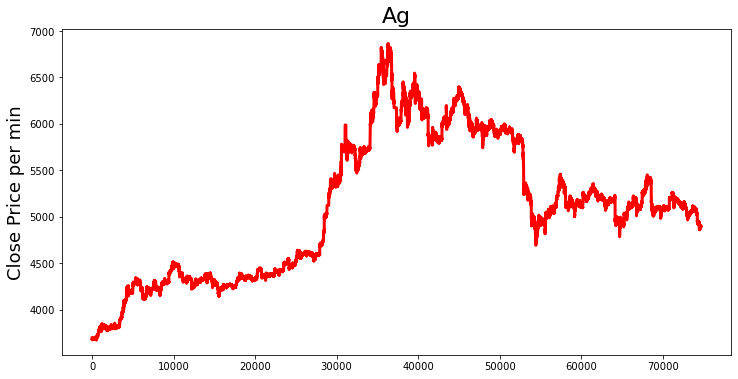

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot((pd.Series(data['ClosePrice'])), lw=3, color='red')
ax.set_title ("Ag", fontsize=22);
ax.set_ylabel ("Close Price per min", fontsize=18);

gc.collect();

## 2.7 每分钟对数收益率

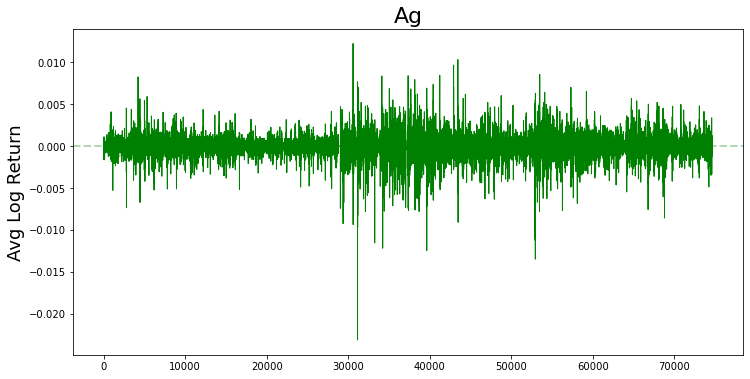

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot((pd.Series(ret)), lw=1, color='green')
ax.axhline(y=0, linestyle='--', alpha=0.3, c='green', lw=2)
ax.set_title ("Ag", fontsize=22);
ax.set_ylabel ("Avg Log Return", fontsize=18);

gc.collect();

## 2.8 每分钟涨跌概率

In [33]:
print("Ag每分钟涨的概率",sum(ret>0)/len(ret))

Ag每分钟涨的概率 0.41176155535322156


In [34]:
print('Ag 每分钟收益率为0的情况',sum(ret == 0)/len(ret))

Ag 每分钟收益率为0的情况 0.17812382839697927


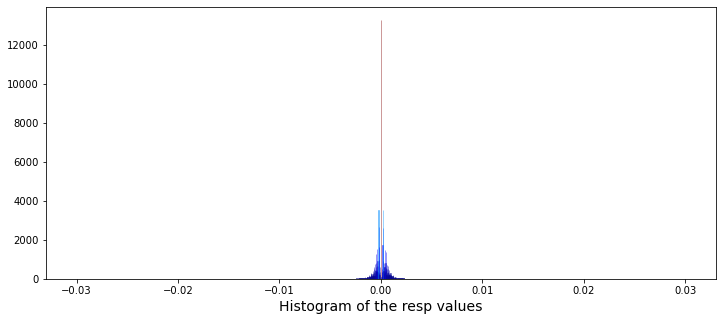

In [35]:
plt.figure(figsize = (12,5))
ax = sns.distplot(ret , 
             bins=3000, 
             kde_kws={"clip":(-0.03,0.03)}, 
             hist_kws={"range":(-0.03,0.03)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the resp values", size=14)
plt.show();
#del values
gc.collect();

收益率17%情况为0导致收益率分布非常尖峰态

In [36]:
min_resp = ret.min()
print('The minimum value for ret is: %.5f' % min_resp)
max_resp = ret.max()
print('The maximum value for ret is:  %.5f' % max_resp)

The minimum value for ret is: -0.02315
The maximum value for ret is:  0.01225


In [37]:
print("Skew of resp is:      %.2f" %ret.skew() )
print("Kurtosis of resp is: %.2f"  %ret.kurtosis() )

Skew of resp is:      -0.93
Kurtosis of resp is: 31.12


删除收益率为0的收益率分布，依然是尖峰态，有许多收益靠近0，

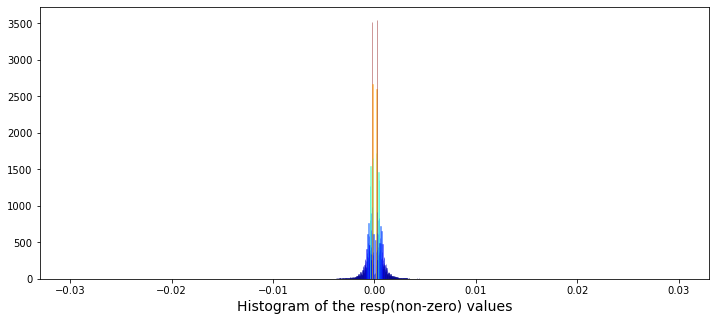

In [38]:
plt.figure(figsize = (12,5))
ax = sns.distplot(ret_nonZero['ret'] , 
             bins=3000, 
             kde_kws={"clip":(-0.03,0.03)}, 
             hist_kws={"range":(-0.03,0.03)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the resp(non-zero) values", size=14)
plt.show();
#del values
gc.collect();

In [39]:
print("Skew of resp(non-zero) is:      %.2f" %ret_nonZero['ret'].skew() )
print("Kurtosis of resp(non-zero) is: %.2f"  %ret_nonZero['ret'].kurtosis() )

Skew of resp(non-zero) is:      -0.85
Kurtosis of resp(non-zero) is: 25.04


## 2.9 特征24：NetBuyVolumn特征93%是0

In [40]:
data['NetBuyVolume'].value_counts()

 0      69545
-1       1424
 1       1152
-2        580
 2        372
        ...  
 35         1
 36         1
-50         1
 101        1
-65         1
Name: NetBuyVolume, Length: 95, dtype: int64

In [41]:
((data[data['NetBuyVolume'] ==0].count()[0])/len(data)).round(2)

0.93

我们考虑直接删除这个特征

# 3 特征工程

目前所通过统计检验的特征列表

In [43]:
features_index = []
for i in range(len(features)):
    features_index.append(features.index[i])
features_index

['ExtraTA_DX',
 'ExtraTA_CCI',
 'ExtraTA_RSI',
 'ExtraTA_CMO',
 'ExtraTA_MINUS_DI',
 'ExtraTA_ULTOSC',
 'ExtraTA_ADX',
 'ImbL1Std',
 'ExtraTA_ADXR',
 'ExtraTA_PLUS_DI',
 'ImbL1Mean',
 'ImbL1Skew',
 'SpreadRatio',
 'ExtraTA_TRIX']

## 3.1Drop特征

In [44]:
#drop return
data['ret'] = (np.log(data['ClosePrice']) - np.log(data['OpenPrice']))
ret = data['ret']

In [45]:
new_data = data.loc[100:,features_index].reset_index(drop=True)
new_data

,ExtraTA_DX,ExtraTA_CCI,ExtraTA_RSI,ExtraTA_CMO,ExtraTA_MINUS_DI,ExtraTA_ULTOSC,ExtraTA_ADX,ImbL1Std,ExtraTA_ADXR,ExtraTA_PLUS_DI,ImbL1Mean,ImbL1Skew,SpreadRatio,ExtraTA_TRIX
0,52.333390,-269.693252,34.489243,-31.021515,34.476637,49.822496,26.362721,0.463141,25.129539,10.788077,0.302821,-1.061269,0.000303,0.000385
1,52.333390,-196.680973,32.678001,-34.643998,32.617594,54.042877,28.217769,0.591307,25.700602,10.206365,0.108925,-0.176556,0.000285,0.000215
2,42.660921,-121.293673,39.519096,-20.961807,30.004103,58.700322,29.249423,0.507661,25.885430,12.059418,-0.215189,0.043417,0.000303,0.000035
3,33.530174,-69.529386,42.656754,-14.686491,28.371983,59.955703,29.555191,0.495547,26.445094,14.123255,-0.073479,0.612179,0.000290,-0.000145
4,24.919888,-45.151893,42.656754,-14.686491,26.801902,58.401328,29.224097,0.435589,26.338259,16.108643,-0.267480,0.167636,0.000280,-0.000322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74579,30.327977,-105.523810,39.184294,-21.631412,25.923760,29.780681,16.079120,0.327677,16.848201,13.858581,-0.419190,0.855608,0.000204,0.001158
74580,39.074420,-150.097466,35.997672,-28.004656,29.138669,28.534198,17.721641,0.477412,17.090044,12.765038,-0.243793,0.475218,0.000208,0.000946
74581,22.511578,-64.702484,47.493848,-5.012304,25.523779,43.682187,18.063780,0.473929,16.804181,16.143758,-0.197999,0.560964,0.000204,0.000747
74582,8.585065,38.547159,51.264752,2.529504,24.228971,48.084497,17.386729,0.693812,16.138814,20.397739,-0.096746,0.154316,0.000211,0.000572


最终我们选取14个特征进行建模

# 4 建模

## 4.1 划分训练集和测试集

前80%数据为训练集，后20%数据为测试集

In [46]:
l = 0.8*len(new_data)
#l

59667.200000000004

In [47]:
y_train = ret.iloc[1:59667].reset_index(drop = True)
y_test = ret.iloc[59767:74584].reset_index(drop = True)

x_train = new_data.iloc[0:59666].reset_index(drop = True)
x_test = new_data.iloc[59766:74583].reset_index(drop = True)

## 4.2 随机森林

In [48]:
%%time
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
#regr_data = regr.fit(x_train,y_train)
regr.fit(x_train,y_train)
RandomForestRegressor(random_state=1)

Wall time: 5min 10s


RandomForestRegressor(random_state=1)

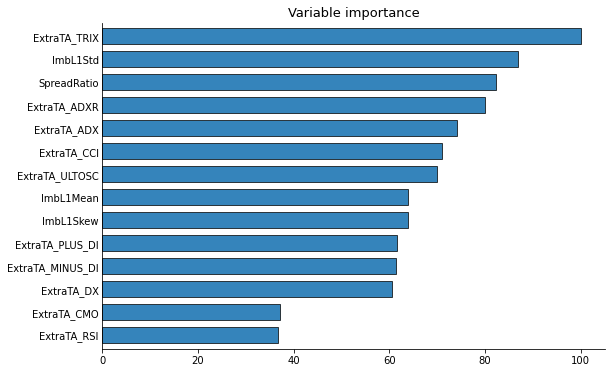

In [49]:
from statlearning import plot_feature_importance
plot_feature_importance(regr, x_train.columns)
plt.show()

In [68]:
%%time

tuning_parameters = {
     'max_depth': [10,20,40],
     'min_samples_leaf': [2,4],
     'min_samples_split': [2,5],
     'n_estimators':  [200,400,600,800]
      }

rf_search = RandomizedSearchCV(regr, tuning_parameters, n_iter = 32, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_search.fit(x_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')


Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best parameters found by randomised search: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10} 

Wall time: 2h 36min 37s


## 4.3Optuna Hyperparam Search for XGBoost

我们使用 PurgedGroupTimeSeriesSplit 进行时序交叉验证 并用Optuna贝叶斯超参数搜索

In [50]:
import xgboost as xgb
import optuna
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
#groups = x_train['Date'].values
groups = x_train.index.values

In [51]:
cv = PurgedGroupTimeSeriesSplit(
    n_splits=5,
    max_train_group_size=18000,
    group_gap=2000,
    max_test_group_size=6000
)

In [52]:
from sklearn.preprocessing import StandardScaler
def objective(trial, cv=cv, cv_fold_func=np.average):

    # Optuna suggest params
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 350, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.10),
        'subsample': trial.suggest_uniform('subsample', 0.50, 0.90),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 0.90),
        #'gamma': trial.suggest_int('gamma', 0, 20),
        #'missing': -999,
        #'tree_method': 'gpu_hist'  
    }
    
    # setup the pieline
    scaler = StandardScaler()
    clf = xgb.XGBRegressor(**params)

    pipe = Pipeline(steps=[
        ('scaler', scaler),
        ('xgb', clf)
    ])


    # fit for all folds and return composite RMSE score
    rmses = []
    for i, (train_idx, valid_idx) in enumerate(cv.split(
        x_train,
        y_train,
        groups=groups)):
        
        train_data = x_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = x_train.iloc[valid_idx, :], y_train.iloc[valid_idx]
        
        _ = pipe.fit(x_train.iloc[train_idx, :], y_train.iloc[train_idx])
        preds = pipe.predict(x_train.iloc[valid_idx, :])
        
        rmse = np.sqrt(mean_squared_error(y_train.iloc[valid_idx], preds))
        rmses.append(rmse)
    
    print(f'Trial done: RMSE values on folds: {rmses}')
    return cv_fold_func(rmses)

In [53]:
gc.collect()

4286

In [54]:
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [55]:
%%time

FIT_XGB = True

n_trials = 10

if FIT_XGB:
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print(" {}: {}".format(key, value))

[I 2021-01-20 16:03:44,010] A new study created in memory with name: no-name-90a87607-c114-40f3-b0ce-e5ba6667156e
[I 2021-01-20 16:05:12,282] Trial 0 finished with value: 0.0009786980415873298 and parameters: {'n_estimators': 440, 'max_depth': 6, 'learning_rate': 0.06795142023558212, 'subsample': 0.5397141354370172, 'colsample_bytree': 0.7775297120498248}. Best is trial 0 with value: 0.0009786980415873298.


Trial done: RMSE values on folds: [0.001012557391935077, 0.001257523530473936, 0.000824920109273821, 0.0009228519223120885, 0.0008756372539417266]


[I 2021-01-20 16:06:11,794] Trial 1 finished with value: 0.0012149995346457934 and parameters: {'n_estimators': 448, 'max_depth': 10, 'learning_rate': 0.014424603595575219, 'subsample': 0.7101340239069679, 'colsample_bytree': 0.5383352191101983}. Best is trial 0 with value: 0.0009786980415873298.


Trial done: RMSE values on folds: [0.0012318217391262092, 0.0014538200106987216, 0.001096764723821894, 0.0011836450487485624, 0.0011089461508335793]


[I 2021-01-20 16:08:42,622] Trial 2 finished with value: 0.000993692050469701 and parameters: {'n_estimators': 948, 'max_depth': 6, 'learning_rate': 0.08296783571863395, 'subsample': 0.6646363643628861, 'colsample_bytree': 0.7501598825735343}. Best is trial 0 with value: 0.0009786980415873298.


Trial done: RMSE values on folds: [0.0010055194012509403, 0.0012742522170562942, 0.0008528171114720609, 0.0009376778056792557, 0.0008981937168899539]


[I 2021-01-20 16:10:42,503] Trial 3 finished with value: 0.0009855123316151642 and parameters: {'n_estimators': 869, 'max_depth': 9, 'learning_rate': 0.07969768901074256, 'subsample': 0.6104947917512549, 'colsample_bytree': 0.6344667777062928}. Best is trial 0 with value: 0.0009786980415873298.


Trial done: RMSE values on folds: [0.0010117329973823492, 0.0012516779651356418, 0.0008458991702006007, 0.0009368727132334217, 0.0008813788121238067]


[I 2021-01-20 16:12:59,179] Trial 4 finished with value: 0.000975741408052493 and parameters: {'n_estimators': 960, 'max_depth': 3, 'learning_rate': 0.08793632075930627, 'subsample': 0.6035950907009904, 'colsample_bytree': 0.8433116766431166}. Best is trial 4 with value: 0.000975741408052493.


Trial done: RMSE values on folds: [0.0010066362880782609, 0.0012655708706650404, 0.0008234574467151898, 0.000915127127089387, 0.0008679153077145865]


[I 2021-01-20 16:15:02,689] Trial 5 finished with value: 0.0009476697266851393 and parameters: {'n_estimators': 931, 'max_depth': 6, 'learning_rate': 0.01870129442778689, 'subsample': 0.7184632501842652, 'colsample_bytree': 0.556953869982122}. Best is trial 5 with value: 0.0009476697266851393.


Trial done: RMSE values on folds: [0.0009991034765029136, 0.001227087503859945, 0.0007971611656332517, 0.0008972633475475404, 0.000817733139882045]


[I 2021-01-20 16:17:37,787] Trial 6 finished with value: 0.0009779379170799314 and parameters: {'n_estimators': 853, 'max_depth': 9, 'learning_rate': 0.06392563649905735, 'subsample': 0.6620748405448702, 'colsample_bytree': 0.7453861443262125}. Best is trial 5 with value: 0.0009476697266851393.


Trial done: RMSE values on folds: [0.0010071863849507004, 0.0012573399430670959, 0.0008319437131461058, 0.0009297687642639192, 0.0008634507799718363]


[I 2021-01-20 16:19:52,577] Trial 7 finished with value: 0.0009522747708421285 and parameters: {'n_estimators': 952, 'max_depth': 4, 'learning_rate': 0.028312834293486557, 'subsample': 0.6092159032307302, 'colsample_bytree': 0.7218368600649944}. Best is trial 5 with value: 0.0009476697266851393.


Trial done: RMSE values on folds: [0.0010015729639458832, 0.001233577331293521, 0.000797977394236036, 0.0009001374707119057, 0.0008281086940232963]


[I 2021-01-20 16:21:51,554] Trial 8 finished with value: 0.0009541440333525429 and parameters: {'n_estimators': 618, 'max_depth': 8, 'learning_rate': 0.025017117505578647, 'subsample': 0.7213177647687339, 'colsample_bytree': 0.705889884238907}. Best is trial 5 with value: 0.0009476697266851393.


Trial done: RMSE values on folds: [0.000998314965894266, 0.0012307397095882874, 0.0008043109017476022, 0.0009088000615620312, 0.000828554527970528]


[I 2021-01-20 16:23:51,820] Trial 9 finished with value: 0.0009495700067185291 and parameters: {'n_estimators': 732, 'max_depth': 6, 'learning_rate': 0.02405654555417836, 'subsample': 0.7968426583499006, 'colsample_bytree': 0.5912351345846654}. Best is trial 5 with value: 0.0009476697266851393.


Trial done: RMSE values on folds: [0.0009986674361362577, 0.0012290359941116073, 0.0008006438311256989, 0.0008976285167237515, 0.0008218742554953301]
Number of finished trials: 10
Best trial:
  Value: 0.0009476697266851393
  Params: 
 n_estimators: 931
 max_depth: 6
 learning_rate: 0.01870129442778689
 subsample: 0.7184632501842652
 colsample_bytree: 0.556953869982122
Wall time: 20min 7s


In [56]:
best_params = trial.params

#best_params['missing'] = -999
#best_params['tree_method'] = 'gpu_hist' 

In [57]:
best_params

{'n_estimators': 931,
 'max_depth': 6,
 'learning_rate': 0.01870129442778689,
 'subsample': 0.7184632501842652,
 'colsample_bytree': 0.556953869982122}

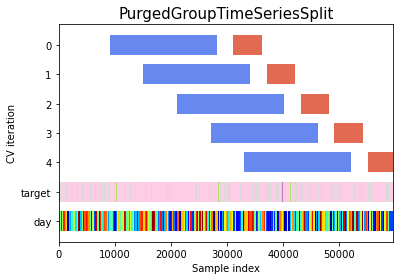

In [59]:
fig, ax = plt.subplots()

cv = PurgedGroupTimeSeriesSplit(
    n_splits=5,
    max_train_group_size=18000,
    group_gap=2000,
    max_test_group_size=6000
)

plot_cv_indices(
    cv,
    x_train,y_train,
    x_train.index.values,
    ax,
    5,
    lw=20
);

In [60]:
##Fit the XGBoost Classifier with Optimal Hyperparams
scaler = StandardScaler()

clf = xgb.XGBRegressor(**best_params)

pipe_xgb = Pipeline(steps=[
    ('scaler', scaler),
    ('xgb', clf)
])

pipe_xgb.fit(x_train,y_train)

gc.collect()

2931

## 4.4 XGboost Random search

In [61]:
%%time
xbst = xgb.XGBRegressor(reg_lambda=0,objective='reg:squarederror', random_state=1)
xbst.fit(x_train,y_train)

Wall time: 6.26 s


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

## 4.5 模型评估

In [70]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(x_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

# Initialise table
columns=['Train RMSE*10^3', 'Test RMSE*10^3','Train MAE*10^3','Test MAE*10^3','Train R^2','Test R^2']
rows=['OLS', 'Random Forest', 'XGBoost(Bayes)', 'XGBoost']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols, rf, pipe_xgb, xbst] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    y_pred_train = method.predict(x_train)
    y_pred_test = method.predict(x_test)
    
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train,y_pred_train))*1000
    results.iloc[i, 1] = np.sqrt(mean_squared_error(y_test,y_pred_test))*1000
    results.iloc[i, 2] = mean_absolute_error(y_train, y_pred_train)*1000
    results.iloc[i, 3] = mean_absolute_error(y_test, y_pred_test)*1000
    results.iloc[i, 4] = r2_score(y_train, y_pred_train)
    results.iloc[i, 5] = r2_score(y_test, y_pred_test) 
    
results.round(6)

,Train RMSE*10^3,Test RMSE*10^3,Train MAE*10^3,Test MAE*10^3,Train R^2,Test R^2
OLS,0.816936,0.686213,0.498409,0.450002,0.000413,0.000186
Random Forest,0.795855,0.686903,0.489184,0.450975,0.051337,-0.001825
XGBoost(Bayes),0.762983,0.688649,0.479568,0.454802,0.128086,-0.006923
XGBoost,0.770085,0.695598,0.485569,0.458625,0.111779,-0.027347


# 5 固定金额回测

## 5.1模型预测

In [71]:
#OLS
predict_ols = pd.Series(ols.predict(x_test))
#Random Forest
predict_rf = pd.Series(rf.predict(x_test))
# Optuna+Purged XGbosst 
pipe_prod = pipe_xgb
predict_xgbt = pd.Series(pipe_prod.predict(x_test))
# Random search XGboost
predict_xg = pd.Series(xbst.predict(x_test))
# Neural Network

## 5.2 回测

In [65]:
open_price = data['OpenPrice']
open_price_test = open_price.iloc[59767:74584].reset_index(drop=True)
#open_price_test

0        5156.5
1        5159.5
2        5152.5
3        5156.5
4        5157.5
          ...  
14812    4883.5
14813    4889.5
14814    4887.5
14815    4906.5
14816    4911.5
Name: OpenPrice, Length: 14817, dtype: float64

In [66]:
from collections import OrderedDict
def get_daily_pnl(testx,testy, period=5, tranct_ratio=False,threshold=0.001, tranct=1.1e-4, noise=0, notional=False,invest = 100):
    n_bar = len(testx)
    price = open_price_test#pd.Series(testx['ClosePrice'].astype('int64')).reset_index(drop=True)
    
    #过去5分钟收益率（滚动）
    ret_5 = (testy.rolling(period).sum()).dropna().reset_index(drop=True)
    ret_5 = ret_5.append(pd.Series([0]*(len(testy)-len(ret_5)))).reset_index(drop=True) 
    #ret_5 = testy
    
    #交易信号 过去5分钟收益大于阈值买入，过去5分钟收益小于负阈值卖出
    signal = pd.Series([0] * n_bar)
    signal[(ret_5>threshold)] = 1
    signal[(ret_5< -threshold)] = -1
   
    #买仓
    position_pos = pd.Series([np.nan] * n_bar)
    position_pos[0] = 0 
    position_pos[(signal==1)] = 1
    position_pos[(ret_5< -threshold)] = 0
    position_pos.ffill(inplace=True)
    
    pre_pos = position_pos.shift(1)#前一分钟持仓情况
    position_pos[(position_pos==1) & (pre_pos==1)] = np.nan #如果前一分钟持有，并且交易信号是1，不执行交易
    position_pos[(position_pos==1)] = invest/price[(position_pos==1)]
    position_pos.ffill(inplace=True)
        
    #卖仓
    position_neg = pd.Series([np.nan] * n_bar)
    position_neg[0] = 0
    position_neg[(signal==-1)] = -1
    position_neg[(ret_5> threshold)] = 0
    position_neg.ffill(inplace=True)
    
    pre_neg = position_neg.shift(1)
    position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
    position_neg[(position_neg==-1)] = -invest/price[(position_neg==-1)]
    position_neg.ffill(inplace=True)
    
    #持仓
    position = position_pos + position_neg
    position[0]=0
    position[n_bar-1] = 0 #交易结束前平仓
    position[n_bar-2] = 0
    change_pos = position - position.shift(1)
    change_pos[0] = 0
    change_base = pd.Series([0] * n_bar)
    change_buy = change_pos>0
    change_sell = change_pos<0

    if (tranct_ratio):
        change_base[change_buy] = price[change_buy]*(1+tranct)
        change_base[change_sell] = price[change_sell]*(1-tranct)
    else:
        change_base[change_buy] = price[change_buy]+tranct
        change_base[change_sell] = price[change_sell]-tranct
    
    final_pnl = -sum(change_base*change_pos)
    pln_invest = final_pnl/invest
    turnover = sum(change_base*abs(change_pos))
    num = sum((position!=0) & (change_pos!=0))
    hld_period = sum(position!=0)
  
    ## finally we combine the statistics into a data frame
    #result = pd.DataFrame({"final.pnl": final_pnl, "turnover": turnover, "num": num, "hld.period": hld_period}, index=[0])
    #result = {"date": date, "final.pnl": final_pnl, "turnover": turnover, "num": num, "hld.period": hld_period}
    result = OrderedDict([ ("pln/invest", pln_invest),("final.pnl", final_pnl), ("turnover", turnover), ("num", num), ("hld.period", hld_period)])
    return result

## 5.3 回测结果

In [72]:
# Initialise table
columns=['pln/invest', 'final.pnl', 'turnover','num','hld.period']
rows=['OLS', 'Random Forest', 'XGBoost(Bayes)', 'XGBoost']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
preds = [predict_ols, predict_rf, predict_xgbt, predict_xg] 
# Compute test predictions and metrics
for i in range(len(preds)):
    results.loc[rows[i]] = pd.DataFrame(get_daily_pnl(x_test,testy = preds[i], period=5, tranct_ratio=True, 
                                               threshold= 0.0005, tranct=0.00015, notional=True, invest = 100),index=[rows[i]]).iloc[0,:]
    
results

,pln/invest,final.pnl,turnover,num,hld.period
OLS,-0.000000,-0.000000,0.000000,0.0,0.0
Random Forest,0.155529,15.552858,1994.156714,10.0,14182.0
XGBoost(Bayes),0.174424,17.442433,9995.643346,50.0,14765.0
XGBoost,0.230773,23.077322,15196.720426,76.0,14440.0
